<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Figure-1:-Causal-graphs-where--$P(Y|do(x))$-is-not-identifiable" data-toc-modified-id="Figure-1:-Causal-graphs-where--$P(Y|do(x))$-is-not-identifiable-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Figure 1: Causal graphs where  $P(Y|do(x))$ is not identifiable</a></span><ul class="toc-item"><li><span><a href="#Figure-1a" data-toc-modified-id="Figure-1a-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Figure 1a</a></span></li><li><span><a href="#Figure-1b" data-toc-modified-id="Figure-1b-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Figure 1b</a></span></li><li><span><a href="#Figure-1c" data-toc-modified-id="Figure-1c-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Figure 1c</a></span></li><li><span><a href="#Figure-1d" data-toc-modified-id="Figure-1d-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Figure 1d</a></span></li><li><span><a href="#Figure-1e" data-toc-modified-id="Figure-1e-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Figure 1e</a></span></li><li><span><a href="#Figure-1f" data-toc-modified-id="Figure-1f-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Figure 1f</a></span></li><li><span><a href="#Figure-1g" data-toc-modified-id="Figure-1g-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Figure 1g</a></span></li><li><span><a href="#Figure-1h" data-toc-modified-id="Figure-1h-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Figure 1h</a></span></li></ul></li><li><span><a href="#Figure-2:-Causal-graphs-admitting-identifiable-effect-$P(y|do(x))$" data-toc-modified-id="Figure-2:-Causal-graphs-admitting-identifiable-effect-$P(y|do(x))$-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Figure 2: Causal graphs admitting identifiable effect $P(y|do(x))$</a></span><ul class="toc-item"><li><span><a href="#Figure-2a" data-toc-modified-id="Figure-2a-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Figure 2a</a></span></li></ul></li></ul></div>

In [1]:
%%writefile identify.py

import networkx as nx
from matplotlib import pylab as plt
import seaborn as sns
import inspect
from collections import OrderedDict
import pgmpy as pgm
from pgmpy.models import BayesianModel
from pgmpy.factors.continuous import ContinuousFactor
from pgmpy.factors.discrete import TabularCPD, JointProbabilityDistribution
from pgmpy.base import DAG
from pgmpy.extern.six.moves import reduce
import numpy as np
import pandas as pd
from numpy.random import randn
from itertools import product
from pgmpy.factors.base import factor_product
from IPython.display import Latex
import sys
from matplotlib.patches import FancyArrowPatch, Circle 


class Fail(Exception):
    pass



def draw_graph( G, U ):
    pos = nx.spring_layout(G)
    V = G.nodes
    #nx.draw(G, pos)
    
    nx.draw_networkx_nodes(G, pos,
                       nodelist=V,
                       node_color='r',
                       node_size=100,
                       alpha=0.8)
    nx.draw_networkx_edges(U, pos,
                       edgelist=list(U.edges),
                       linestyle='dashed',
                       arrows=True,
                       arrowstyle='<|-|>',
                       connectionstyle="arc3,rad=0.3",
                       width=3, alpha=0.5)
    nx.draw_networkx_edges(G, pos,
                          edgelist=list(G.edges),
                          style='solid',
                          width=2, alpha=0.5)
    nx.draw_networkx_labels(G, pos)
    plt.show()

def to_frame(self, tablefmt="fancy_grid", print_state_names=True):
        headers_list = []
        # build column headers

        evidence = self.variables[1:]
        evidence_card = self.cardinality[1:]
        if evidence:
            col_indexes = np.array(list(product(*[range(i) for i in evidence_card])))
            if self.state_names and print_state_names:
                for i in range(len(evidence_card)):
                    column_header = [str(evidence[i])] + ['{var}({state})'.format
                                                     (var=evidence[i],
                                                      state=self.state_names[evidence[i]][d])
                                                     for d in col_indexes.T[i]]
                    headers_list.append(column_header)
            else:
                for i in range(len(evidence_card)):
                    column_header = [str(evidence[i])] + ['{s}_{d}'.format(s=evidence[i], d=d) 
                                                          for d in col_indexes.T[i]]
                    headers_list.append(column_header)

        # Build row headers
        if self.state_names and print_state_names:
            variable_array = [['{var}({state})'.format
                               (var=self.variable, state=self.state_names[self.variable][i])
                               for i in range(self.variable_card)]]
        else:
            variable_array = [['{s}_{d}'.format(s=self.variable, d=i) for i in range(self.variable_card)]]
        # Stack with data
        labeled_rows = np.hstack((np.array(variable_array).T, self.get_values())).tolist()
        # No support for multi-headers in tabulate
        if len(headers_list) > 0:
            column_idx = pd.MultiIndex.from_arrays([header[1:] for header in headers_list],
                                              names= [header[0] for header in headers_list])
            row_idx_name = 'P({}|{})'.format(self.variable, ','.join(column_idx.names))
        else:
            column_idx = [self.variable]
            row_idx_name = 'P({})'.format(self.variable)
        df = pd.DataFrame(self.get_values(), columns=column_idx, index=variable_array)
        df.index.name = row_idx_name
        return df

def adjacent_nodes( pairs, node ):
    "Returns the nodes adjacent to node (via the bidirected edges in pairs)."
    adjacent_nodes = set()
    for pair in pairs:
        if node in pair:
            adjacent_nodes |= set(pair)
    return list(adjacent_nodes - set([node]))
   
def factorize_c_components( U ):
    """Returns the confounded components of G as a list of sets of vertices"""
    def recur(nodes = list(U.nodes), components = list()):
        if len(nodes) == 0:
            return components
        else:
            current_node = nodes[0]
            current_component = connected_component( U.edges ,
                                                     current_node )
            print('found connected component {} of node {}'.format(current_component, current_node))
            
            return recur( list(set(nodes[1:]) - current_component ),
                          components + [current_component] ) 
    return recur()
def connected_component( pairs, node ):
    def recur( frontier=[node], visited=set() ):
        if len(frontier) == 0:
            return visited
        else:
            current = frontier[0]
            if current in visited:
                return recur( frontier[1:], visited )
            else:
                visited.add( current )
                return recur( frontier[1:] + adjacent_nodes( pairs, current),
                              visited )
    return recur( )


def remove_nodes_from( G , x ):
    G_x = G.copy()
    G_x.remove_nodes_from( x )
    return G_x

def predecessors( pi, v ):
    return pi[:pi.index(v)]

def marginalize( marginals, P ):
    return [Pv.marginalize( (set(Pv.scope()) & marginals) - set([Pv.variable]),
                          inplace=False)
           for Pv in P]
def sum_product(  marginals, P ):
    if len(P) > 1:
        return factor_product( *P ).\
               marginalize( marginals, inplace=False )
    elif len(P) == 1:
        return P[0].marginalize( marginals, inplace=False )
    else:
        raise NameError("P is empty!")
        
def cut_incoming( G, x ):
    G_x = G.copy()
    for edge in G.edges:
        if edge[1] in x:
            G_x.remove_edge( *edge )
    return G_x
def draw_bidirected_graph( bigraph ):
    pos = nx.spring_layout(bigraph)
    nx.draw(bigraph, pos)
    nx.draw_networkx_labels(bigraph, pos)
    plt.show()

def find_superset( C_component, s ):
    for s_prime in C_component:
        if len(s - s_prime) == 0:
            return s_prime
    return []
    
def ID( y, x, P, G, U ):
    print('Y: {}\nX: {}'.format(y, x))
    [display(to_frame(cpd)) for cpd in P]
    draw_graph( G, U)
    v = set(G.nodes)
    # line 1
    if len(x) == 0:
        print('Line 1')
        return sum_product( v - y,  P )
    # line 2
    ancestors_y = G._get_ancestors_of( list(y) )
    if len(v - ancestors_y) > 0:
        print('Line 2')
        ID( y, 
            x & ancestors_y,
           marginalize( v - ancestors_y, P ),
           G.subgraph( ancestors_y ),
           U.subgraph( ancestors_y )
          )
    
    # line 3
    G_bar_x = cut_incoming( G, x )
    w = (v - x) - G_bar_x._get_ancestors_of( list(y) )
    if len( w ) > 0:
        print('Line 3')
        ID( y, x | w, P, G, U )
        
    # line 4
    U_x = remove_nodes_from( U, x )
    C_components_of_U_x = factorize_c_components( U_x )
    print('C_x: {}'.format(C_components_of_U_x))
    if len(C_components_of_U_x) > 1:
        print('Line 4')
        return sum_product( v - (x|y), 
                            [ID(  C_component, 
                                  v - C_component,
                                  P,
                                  G,
                                  U )
                            for C_component in C_components_of_U_x] )

    elif len(C_components_of_U_x) == 1:

        # line 5
        S_x = C_components_of_U_x[0]
        C_components_of_U = factorize_c_components( U )
        if len(C_components_of_U) == 1 and C_components_of_U[0] == v:
            print('Line 5')
            raise Fail( 
                "C_components_of_U {} and C_components_of_U_x {} form a hedge".format(
                    C_components_of_U, C_components_of_U_x ))
        # line 6
        pi = nx.topological_sort( G )
        if S_x  in C_components_of_U:
            print('Line 6')
            return sum_product(S_x - y, 
                               [Pv_given_pi 
                                for Pv_given_pi in P
                                if Pv_i_given_v_pi.variable in S_x] )
        # line 7
        S_prime = find_superset( C_components_of_U, S_x )  
        if len(S_prime) > 0:
            print('Line 7')
            print('Found superset: {}'.format( S_prime))
            P_prime = [Pv
                       for Pv in P
                       if Pv.variable in S_prime ]
            return ID( y,
                       x & S_prime,
                       P_prime,
                       G.subgraph( S_prime ), 
                       U.subgraph( S_prime )
                     )
        else:
            raise Error("S' is empty")
    else:
        raise Error("ID preconditions failed. C_x is empty")


Overwriting identify.py


In [7]:
%matplotlib inline
from identify import draw_graph, ID
from pgmpy.models import BayesianModel
from pgmpy.factors.continuous import ContinuousFactor
from pgmpy.factors.discrete import TabularCPD, JointProbabilityDistribution
from pgmpy.base import DAG
import pandas as pd
import numpy as np
import sympy as sy

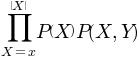

In [29]:
from sympy import Function, Symbol, Eq, simplify, init_printing
from sympy.concrete.summations import Sum
from sympy.concrete.products import Product
from sympy.functions import Abs
init_printing()
X, Y = Symbol('X'), Symbol('Y')
x = Symbol('x')
P= Function('P')
Product(P(X,Y)*P(X),(X,x,Abs(X)))

# Figure 1: Causal graphs where  $P(Y|do(x))$ is not identifiable

## Figure 1a

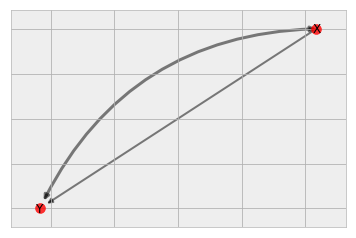

In [3]:
figure_1a = dict(G=BayesianModel([('X','Y')]),
                 U=DAG([('X','Y')]))

draw_graph(**figure_1a)
            
                 

Y: frozenset({'Y'})
X: frozenset({'X'})


,X
X(0),0.492
X(1),0.508


X,X(0),X(1)
Y(0),0.522358,0.464567
Y(1),0.477642,0.535433


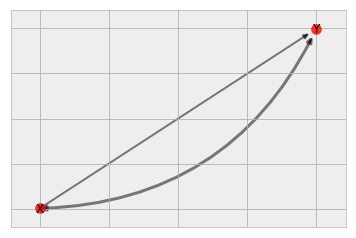

found connected component {'Y'} of node Y
C_x: [{'Y'}]
found connected component {'Y', 'X'} of node X
Line 5


Fail: C_components_of_U [{'Y', 'X'}] and C_components_of_U_x [{'Y'}] form a hedge

In [4]:
U = figure_1a['U']
G = figure_1a['G']
x, y = frozenset({'X'}), frozenset({'Y'})

data = pd.DataFrame(np.random.randint(low=0, high=2, size=(1000,2)),
                   columns=['X','Y'])

G.fit(data)
G.check_model()


P = G.get_cpds()

ID(y, x, P, G, U)

## Figure 1b

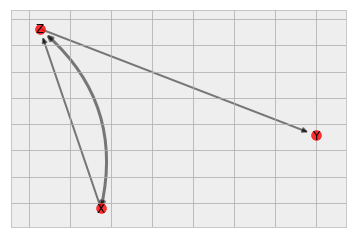

In [5]:
figure_1b = dict(G=BayesianModel([('X','Z'),
                        ('Z','Y')]),
                 U =DAG([('X','Z')]))
draw_graph(**figure_1b)

Y: frozenset({'Y'})
X: frozenset({'X'})


,X
X(0),0.485
X(1),0.515


Z,Z(0),Z(1)
Y(0),0.486974,0.528942
Y(1),0.513026,0.471058


X,X(0),X(1)
Z(0),0.517526,0.481553
Z(1),0.482474,0.518447


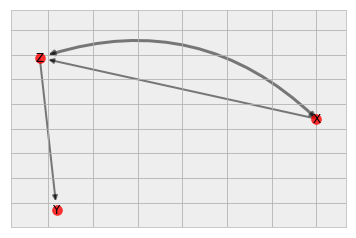

found connected component {'Z'} of node Z
C_x: [{'Z'}]
found connected component {'Z', 'X'} of node X
Line 7
Found superset: {'Z', 'X'}
Y: frozenset({'Y'})
X: frozenset({'X'})


,X
X(0),0.485
X(1),0.515


X,X(0),X(1)
Z(0),0.517526,0.481553
Z(1),0.482474,0.518447


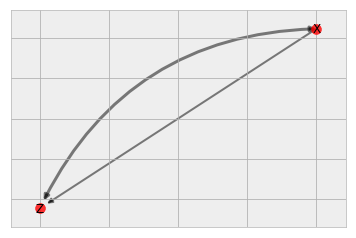

ValueError: Node Y not in not in graph

In [6]:
U = figure_1b['U']
G = figure_1b['G']
x, y = frozenset({'X'}), frozenset({'Y'})

data = pd.DataFrame(np.random.randint(low=0, high=2, size=(1000,len(G.nodes))),
                   columns=list(G.nodes))

G.fit(data)
G.check_model()


P = G.get_cpds()

ID(y, x, P, G, U)

Y: frozenset({'Y'})
X: frozenset({'X'})


,X
X(0),0.502
X(1),0.498


X,X(0),X(1)
Y(0),0.525896,0.493976
Y(1),0.474104,0.506024


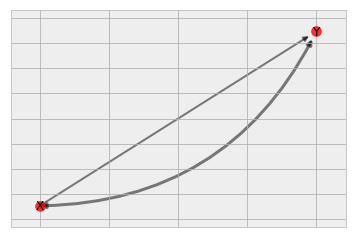

found connected component {'Y'} of node Y
C_x: [{'Y'}]
found connected component {'Y', 'X'} of node X
Line 5


Fail: C_components_of_U [{'Y', 'X'}] and C_components_of_U_x [{'Y'}] form a hedge

In [35]:
U = figure_1a['U']
G = figure_1a['G']
x, y = frozenset({'X'}), frozenset({'Y'})

data = pd.DataFrame(np.random.randint(low=0, high=2, size=(1000,len(G.nodes))),
                   columns=list(G.nodes))

G.fit(data)
G.check_model()


P = D.get_cpds()

ID(y, x, P, G, U)

## Figure 1c

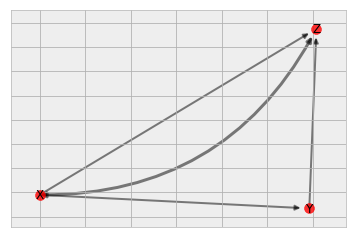

In [34]:
figure_1c = dict(G=DAG([('X','Z'),
                        ('X','Y'),
                        ('Y','Z')]),
                 U=DAG([('X', 'Z')]))
draw_graph(**figure_1c)

## Figure 1d

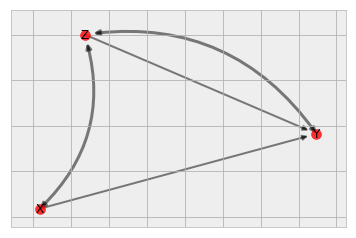

In [57]:
figure_1d = dict(G=DAG([('X','Y'),
                        ('Z','Y')]),
                 U=DAG([('X', 'Z'),
                       ('Y', 'Z')]))
draw_graph(**figure_1d)

## Figure 1e

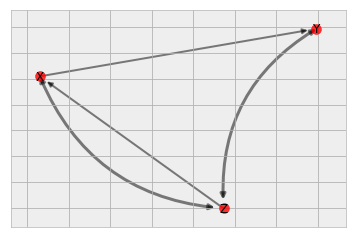

In [58]:
figure_1e = dict(G=DAG([('Z','X'),
                        ('X','Y')]),
                 U=DAG([('X', 'Z'),
                       ('Y', 'Z')]))
draw_graph(**figure_1e)

## Figure 1f

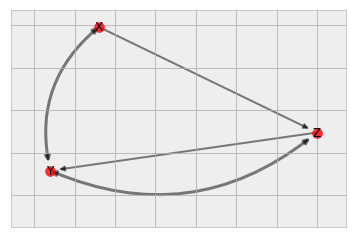

In [60]:
figure_1f = dict(G=DAG([('X','Z'),
                        ('Z','Y')]),
                 U=DAG([('X', 'Y'),
                       ('Y', 'Z')]))
draw_graph(**figure_1f)

## Figure 1g

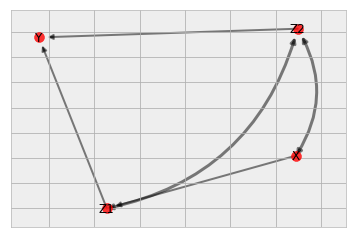

In [61]:
figure_1g = dict(G=DAG([('X','Z1'),
                        ('Z2','Y'),
                        ('Z1', 'Y')]),
                 U=DAG([('X', 'Z2'),
                       ('Z1', 'Z2')]))
draw_graph(**figure_1g)

## Figure 1h

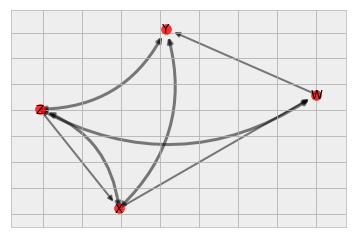

In [62]:
figure_1h = dict(G=DAG([('Z','X'),
                        ('X','W'),
                        ('W', 'Y')]),
                 U=DAG([('X', 'Z'),
                       ('X', 'Y'),
                       ('Z', 'W'),
                       ('Z', 'Y')]))
draw_graph(**figure_1h)

# Figure 2: Causal graphs admitting identifiable effect $P(y|do(x))$

## Figure 2a

In [ ]:
figure_2a = 

In [5]:
D = BayesianModel([('W1','X'),
                   ('X','Y1'),
                   ('W2','Y2')])

U = nx.Graph([('W1','Y1'),
             ('W1','W2'),
             ('W2','X'),
             ('W1','Y2'),
             #('W2', 'Y2')
             ])

data = pd.DataFrame(np.random.randint(low=0, high=2, size=(1000,5)),
                   columns=['X','Y1','Y2','W1','W2'])

D.fit(data)
D.get_cpds()
D.check_model()

y = frozenset(['Y1', 'Y2'])
x = frozenset(['X'])
P = D.get_cpds()
G = DAG(D.edges)


Y: frozenset({'Y2', 'Y1'})
X: frozenset({'X'})


,W1
W1(0),0.515
W1(1),0.485


,W2
W2(0),0.497
W2(1),0.503


W1,W1(0),W1(1)
X(0),0.473786,0.513402
X(1),0.526214,0.486598


X,X(0),X(1)
Y1(0),0.503043,0.544379
Y1(1),0.496957,0.455621


W2,W2(0),W2(1)
Y2(0),0.527163,0.471173
Y2(1),0.472837,0.528827


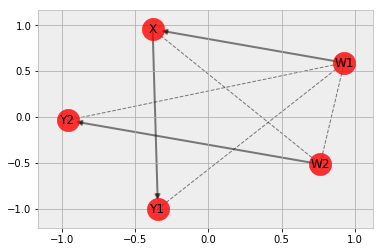

Line 3
Y: frozenset({'Y2', 'Y1'})
X: frozenset({'X', 'W1'})


,W1
W1(0),0.515
W1(1),0.485


,W2
W2(0),0.497
W2(1),0.503


W1,W1(0),W1(1)
X(0),0.473786,0.513402
X(1),0.526214,0.486598


X,X(0),X(1)
Y1(0),0.503043,0.544379
Y1(1),0.496957,0.455621


W2,W2(0),W2(1)
Y2(0),0.527163,0.471173
Y2(1),0.472837,0.528827


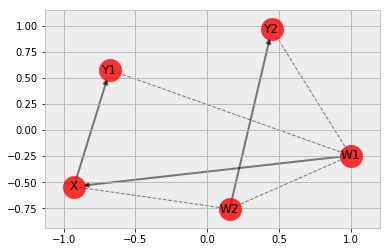

found connected component {'Y1'} of node Y1
found connected component {'Y2'} of node Y2
found connected component {'W2'} of node W2
C_x: [{'Y1'}, {'Y2'}, {'W2'}]
Line 4
Y: {'Y1'}
X: {'Y2', 'W1', 'W2', 'X'}


,W1
W1(0),0.515
W1(1),0.485


,W2
W2(0),0.497
W2(1),0.503


W1,W1(0),W1(1)
X(0),0.473786,0.513402
X(1),0.526214,0.486598


X,X(0),X(1)
Y1(0),0.503043,0.544379
Y1(1),0.496957,0.455621


W2,W2(0),W2(1)
Y2(0),0.527163,0.471173
Y2(1),0.472837,0.528827


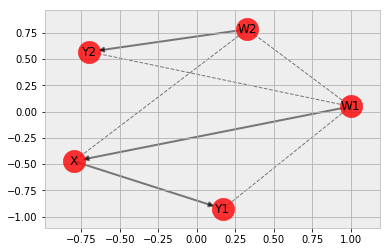

Line 2
Y: {'Y1'}
X: {'W1', 'X'}


,W1
W1(0),0.515
W1(1),0.485


,W2
W2(0),0.497
W2(1),0.503


W1,W1(0),W1(1)
X(0),0.473786,0.513402
X(1),0.526214,0.486598


X,X(0),X(1)
Y1(0),0.503043,0.544379
Y1(1),0.496957,0.455621


,Y2
Y2(0),0.499168
Y2(1),0.500832


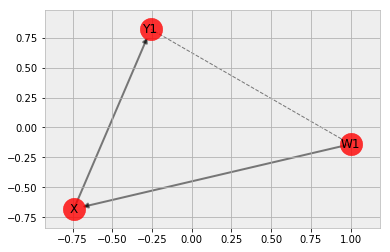

found connected component {'Y1'} of node Y1
C_x: [{'Y1'}]
found connected component {'Y1', 'W1'} of node W1
found connected component {'X'} of node X
Line 7
Found superset: {'Y1', 'W1'}
Y: {'Y1'}
X: {'W1'}


,W1
W1(0),0.515
W1(1),0.485


X,X(0),X(1)
Y1(0),0.503043,0.544379
Y1(1),0.496957,0.455621


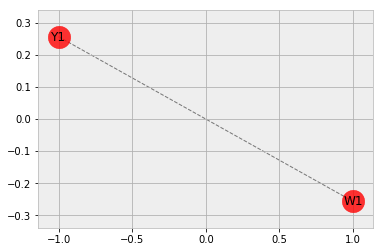

Line 2
Y: {'Y1'}
X: set()


,W1
W1(0),0.515
W1(1),0.485


X,X(0),X(1)
Y1(0),0.503043,0.544379
Y1(1),0.496957,0.455621


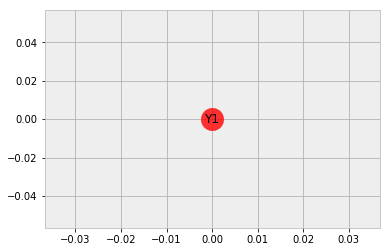

Line 1
found connected component {'Y1'} of node Y1
C_x: [{'Y1'}]
found connected component {'Y1', 'W1'} of node Y1
Line 5


Fail: C_components_of_U [{'Y1', 'W1'}] and C_components_of_U_x [{'Y1'}] form a hedge

In [14]:
ID(y, x, P, G, U)